<a href="https://colab.research.google.com/github/myadav97/BankNifty-Price-Predication/blob/main/BankNifty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [21]:
!pip install mplcursors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import mplcursors


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mplcursors: filename=mplcursors-0.5.2-py3-none-any.whl size=21048 sha256=726781dd32e69ca8376f00f10a334ae922608e72e79fb7ac99f320de008b1e26
  Stored in directory: /root/.cache/pip/wheels/b5/5b/fb/aed35cc15262c380536820fa3cb2e2d41fb52450de918a6785
Successfully built mplcursors


## Load Dataset

In [3]:
data = pd.read_csv('/content/bank_nifty_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Extract the 'Open' and 'Close' prices as the target variables

In [4]:
df = data[['Open', 'Close']]

## Normalize the data using Min-Max scaling

In [5]:
scaler = MinMaxScaler()
df[['Open', 'Close']] = scaler.fit_transform(df[['Open', 'Close']])

<ipython-input-5-d3a3dc454a44>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Open', 'Close']] = scaler.fit_transform(df[['Open', 'Close']])


## Define the number of previous days to use for prediction

In [6]:
look_back = 30  # You can adjust this value

## Create sequences of data for training

In [7]:
X, y_open, y_close = [], [], []

for i in range(look_back, len(df)):
    X.append(df.iloc[i - look_back:i, :].values)
    y_open.append(df.iloc[i, 0])
    y_close.append(df.iloc[i, 1])

X, y_open, y_close = np.array(X), np.array(y_open), np.array(y_close)

## Split the data into training and testing sets

In [8]:
split = int(0.8 * len(X))
X_train, X_test, y_open_train, y_open_test, y_close_train, y_close_test = X[:split], X[split:], y_open[:split], y_open[split:], y_close[:split], y_close[split:]


# Build the LSTM model

In [9]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 2)))
model.add(LSTM(units=50))
model.add(Dense(units=2))  # Output two values: Open and Close

# Compile the model

In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')


# Train the model

In [13]:
model.fit(X_train, np.column_stack((y_open_train, y_close_train)), epochs=50, batch_size=32)


Epoch 1/50
91/91 [==============================] - 3s 19ms/step - loss: 4.2887e-05
Epoch 2/50
91/91 [==============================] - 2s 19ms/step - loss: 5.3386e-05
Epoch 3/50
91/91 [==============================] - 2s 20ms/step - loss: 5.5100e-05
Epoch 4/50
91/91 [==============================] - 2s 25ms/step - loss: 3.8646e-05
Epoch 5/50
91/91 [==============================] - 2s 19ms/step - loss: 4.1971e-05
Epoch 6/50
91/91 [==============================] - 2s 18ms/step - loss: 4.2677e-05
Epoch 7/50
91/91 [==============================] - 2s 20ms/step - loss: 4.1579e-05
Epoch 8/50
91/91 [==============================] - 2s 19ms/step - loss: 3.7785e-05
Epoch 9/50
91/91 [==============================] - 2s 19ms/step - loss: 6.3613e-05
Epoch 10/50
91/91 [==============================] - 2s 20ms/step - loss: 4.9046e-05
Epoch 11/50
91/91 [==============================] - 2s 24ms/step - loss: 4.0819e-05
Epoch 12/50
91/91 [==============================] - 2s 19ms/step - loss: 

# Make predictions on the test set

In [15]:
y_pred = model.predict(X_test)

23/23 [==============================] - 0s 6ms/step


# Inverse transform the predictions to get the actual stock prices

In [16]:
y_pred = scaler.inverse_transform(y_pred)
y_open_pred = y_pred[:, 0]
y_close_pred = y_pred[:, 1]

# Calculate the predicted future open and close prices

In [19]:
predicted_future_open = y_open_pred[-1]
predicted_future_close = y_close_pred[-1]

# Print the predicted future open and close prices
print(f"Predicted Future Open Price: {predicted_future_open}")
print(f"Predicted Future Close Price: {predicted_future_close}")

Predicted Future Open Price: 43865.15234375
Predicted Future Close Price: 43588.43359375


# Plot the results for both Open and Close prices

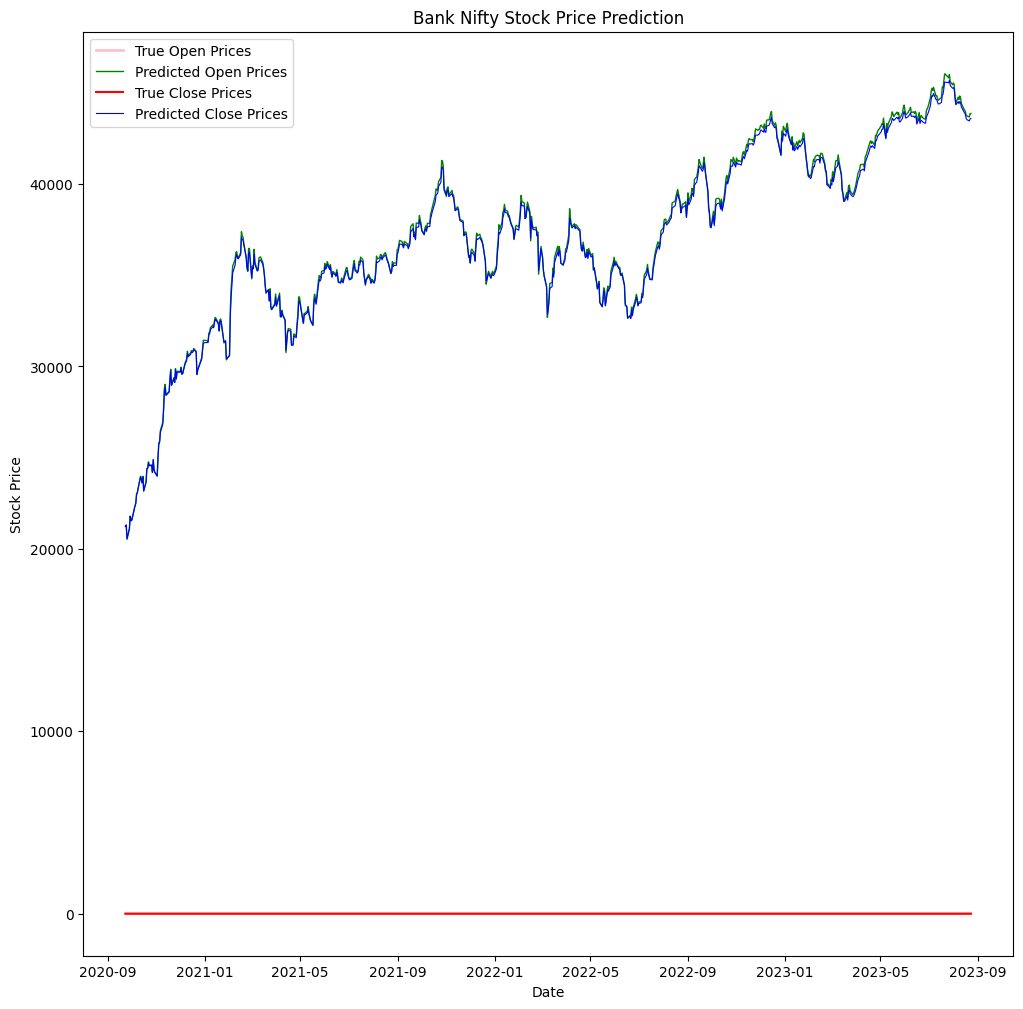

In [28]:
# Plot the results for both Open and Close prices
plt.figure(figsize=(12, 12))
plt.plot(data.index[split + look_back:], y_open_test, label='True Open Prices', color='pink',linewidth=2.0)
plt.plot(data.index[split + look_back:], y_open_pred, label='Predicted Open Prices', color='green',linewidth=1.0)
plt.plot(data.index[split + look_back:], y_close_test, label='True Close Prices', color='red',linewidth=1.5)
plt.plot(data.index[split + look_back:], y_close_pred, label='Predicted Close Prices', color='blue',linewidth=0.8)
plt.legend()
plt.title('Bank Nifty Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')

# Use mplcursors to display current prices on hover
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(
    f"Date: {sel.target[0].strftime('%Y-%m-%d %H:%M')}\nOpen: {sel.target[2]:.2f}\nClose: {sel.target[1]:.2f}"))

plt.show()